In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn as nn
from torch.utils.data import DataLoader, TensorDataset
from mamba import S4,S4Regressor

In [25]:
BATCH_SIZE = 8
seq_len = 16
channels = 2
N_SAMPLES = 512

torch.manual_seed(0)
X = torch.randn(N_SAMPLES, seq_len, channels)
Y = (X[:, :, 0] + 0.5 * torch.roll(X[:, :, 1], shifts=1, dims=1)).unsqueeze(-1)

dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

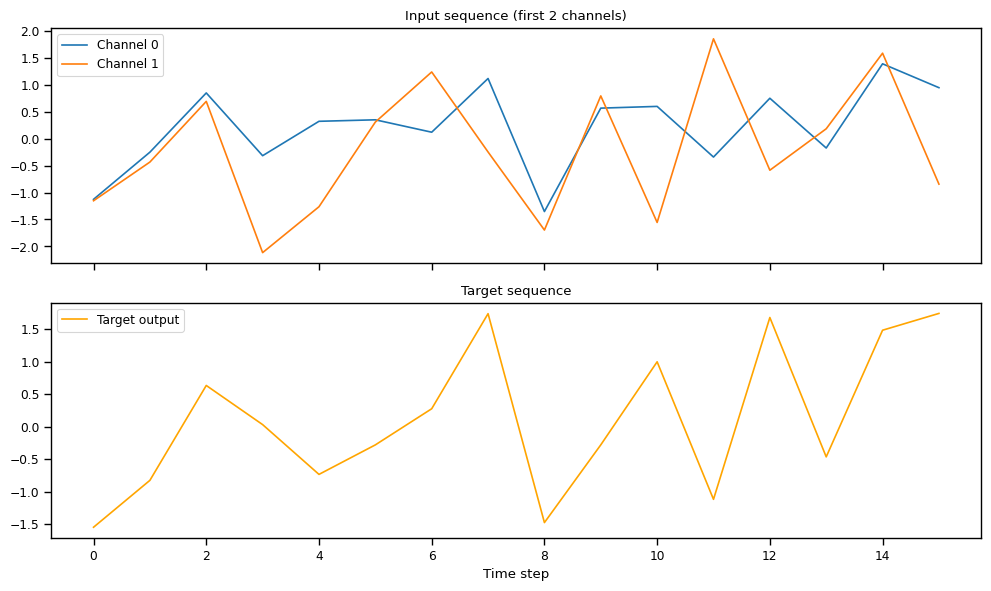

In [26]:
sample_x, sample_y = dataset[0]
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Plot first few channels of input
ax[0].plot(sample_x[:, 0].numpy(), label="Channel 0")
ax[0].plot(sample_x[:, 1].numpy(), label="Channel 1")
ax[0].set_title("Input sequence (first 2 channels)")
ax[0].legend()

# Plot target
ax[1].plot(sample_y.squeeze().numpy(), color='orange', label="Target output")
ax[1].set_title("Target sequence")
ax[1].legend()

plt.xlabel("Time step")
plt.tight_layout()
plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = S4Regressor(channels=channels, hidden_dim=30,depth=1).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-10, weight_decay=1e-4)

EPOCHS = 5
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        # Forward pass
        pred = model(xb)
        loss = nn.functional.mse_loss(pred, yb)

        # Backward + update
        opt.zero_grad()
        loss.backward()
        opt.step()

        total_loss += loss.item() * xb.size(0)

    avg_loss = total_loss / len(dataset)
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.6f}")

# -------------------------
# 5. Inference example
# -------------------------
model.eval()
test_in = torch.randn(1, seq_len, channels).to(device)
with torch.no_grad():
    test_out = model(test_in)
print("Test output shape:", test_out.shape)

In [ ]:
#new s4

In [36]:
from functools import partial
import jax
import jax.numpy as np
from flax import linen as nn
from jax.nn.initializers import lecun_normal, normal
from jax.numpy.linalg import eigh, inv, matrix_power
from jax.scipy.signal import convolve

def example_mass(k, b, m):
    A = torch.tensor([[0, 1], [-k / m, -b / m]])
    B = torch.tensor([[0], [1.0 / m]])
    C = torch.tensor([[1.0, 0]])
    return A, B, C

@partial(np.vectorize, signature="()->()")
def example_force(t):
    x = np.sin(10 * t)
    return x * (x > 0.5)

ssm = example_mass(k=40, b=5, m=1)
L = 100
step = 1.0 / L
ks = np.arange(L)
u = torch.tensor(example_force(ks * step))
simple_S4 = S4(channels=1,hidden_state= 2,min_delta=1e-3,eps=1e-6,use_hippo=False,seed=42)
simple_S4.A = ssm[0]
simple_S4.B = ssm[1]
simple_S4.C = ssm[2]
print(u.shape)
y = simple_S4.propagate_RNN(u)
print(y.shape)

torch.Size([100])
tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  2.7517e-05,  1.1250e-04,  2.5925e-04,  4.7097e-04,
          7.4972e-04,  1.0964e-03,  1.5108e-03,  1.9914e-03,  2.5359e-03,
          3.1406e-03,  3.8008e-03,  4.5112e-03,  5.2651e-03,  6.0553e-03,
          6.8738e-03,  7.7120e-03,  8.5608e-03,  9.4106e-03,  1.0251e-02,
          1.1074e-02,  1.1867e-02,  1.2600e-02,  1.3248e-02,  1.3814e-02,
          1.4297e-02,  1.4702e-02,  1.5029e-02,  1.5282e-02,  1.5463e-02,
          1.5575e-02,  1.5621e-02,  1.5604e-02,  1.5526e-02,  1.5392e-02,
          1.5204e-02,  1.4967e-02,  1.4682e-02,  1.4354e-02,  1.3986e-02,
          1.3582e-02,  1.3144e-02,  1.2677e-02,  1.2182e-02,  1.1665e-02,
          1.1127e-02,  1.0572e-02,  1.0002e-02,  9.4219e-03,  8.8330e-03,
          8.2383e-03,  7.6405e-03,  7.0420e-03,  6.4452e-03,  5.8524e-03,
          5.2657e-03,  4.6870e-03,  4.1183e-03,  3.5612e-03,  3.0174e-03,
          2.4883e-03

In [31]:
u.shape

torch.Size([100])

In [ ]:
# Plotting ---
import matplotlib.pyplot as plt
import seaborn
from celluloid import Camera

seaborn.set_context("paper")
fig, (ax1, ax2, ax3) = plt.subplots(3)
camera = Camera(fig)
ax1.set_title("Force $u_k$")
ax2.set_title("Position $y_k$")
ax3.set_title("Object")
ax1.set_xticks([], [])
ax2.set_xticks([], [])

# Animate plot over time
for k in range(0, L, 2):
    ax1.plot(ks[:k], u[:k], color="red")
    ax2.plot(ks[:k], y[:k], color="blue")
    ax3.boxplot(
        [[y[k] - 0.04, y[k], y[k] + 0.04]],
        showcaps=False,
        whis=False,
        vert=False,
        widths=10,
    )
    camera.snap()
anim = camera.animate()
anim.save("./line.gif", dpi=150, writer="imagemagick")

/tmp/ipykernel_6729/574394595.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


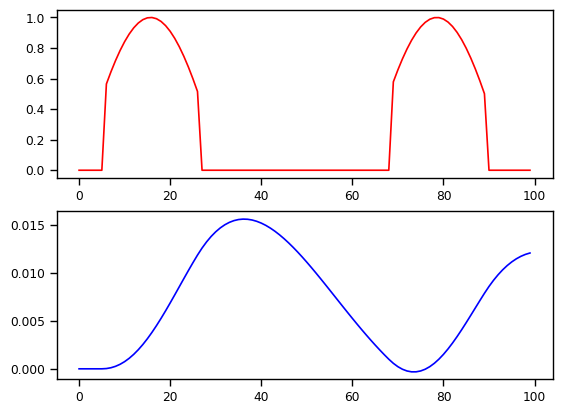

In [39]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(ks[:L], u[:L], color="red")
ax2.plot(ks[:L], y[:L], color="blue")
fig.show()

In [61]:
#train the model
A = torch.zeros((3,7))
A[1,:] = 1
k = torch.zeros((3,3,7))
k[0,2,:] = 2
k[1,2,:] = 2
k[1,1,:] = 1

A_pad = torch.nn.functional.pad(A,(0,7))
y  = torch.nn.functional.conv1d(A_pad,k,bias=None)
print(y)

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [7., 6., 5., 4., 3., 2., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [69]:
k_pad = torch.nn.functional.pad(k,(0,7))
dA = torch.fft.rfft(A_pad)
dk = torch.fft.rfft(k_pad)
print(dA.shape)
print(dk.shape)
prod = torch.einsum('odf,df->of',dk,dA)
prod = torch.fft.irfft(prod)[:,:7]
print(prod)

torch.Size([3, 8])
torch.Size([3, 3, 8])
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 2.0000, 3.0000, 4.0000, 5.0000, 6.0000, 7.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
